# Fake News Detection – Capstone3 Project

## Objective
The goal of this project is to build a machine learning/NLP model
to detect whether a news article is **fake** or **real**.

This notebook focuses on:
- Dataset exploration (EDA for text)
- Data quality checks
- Baseline model training
- Model evaluation


✅ This notebook includes :

- Imports
- Dataset structure & loading
- EDA & class distribution
- Text preprocessing
- TF-IDF + Logistic Regression baseline
- PyTorch feedforward model
- Training & validation loops
- F1-score + confusion matrices

Observations & conclusion
Production deployment, monitoring, and API orchestration
are implemented separately in scripts.

### Imports

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

### Dataset Structure Check

In [2]:
DATA_DIR = "data/processed"

for split in ["train.csv", "val.csv", "test.csv"]:
    path = os.path.join(DATA_DIR, split)
    df = pd.read_csv(path)
    print(f"\n{split.upper()}")
    print(f"Number of samples: {len(df)}")
    print("Class distribution:")
    print(df['label'].value_counts())


TRAIN.CSV
Number of samples: 31428
Class distribution:
label
0    16437
1    14991
Name: count, dtype: int64

VAL.CSV
Number of samples: 6735
Class distribution:
label
0    3522
1    3213
Name: count, dtype: int64

TEST.CSV
Number of samples: 6735
Class distribution:
label
0    3522
1    3213
Name: count, dtype: int64


### Visualize Sample Texts (EDA)

In [5]:
def show_samples(df, label, n=5):
    """
    label: 'fake' or 'real'
    """
    label_map = {"fake": 0, "real": 1}
    numeric_label = label_map[label]
    
    print(f"\nSamples from class '{label}':\n")
    samples = df[df['label']==numeric_label]['text'].sample(n)
    for i, text in enumerate(samples):
        print(f"{i+1}. {text[:500]}...\n")  # show first 500 chars

train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
show_samples(train_df, "fake")
show_samples(train_df, "real")



Samples from class 'fake':

1. Republicans insist that everything under President Obama is awful and terrible and getting worse. Their nominee for the presidency has based his entire candidacy on the idea that America is a complete trianwreck and only he  alone  can fix things.But when you ask actual Americans about what their lives are like after eight years of Barack Obama being president, a completely different message emerges. Gallup did just that, in a survey of over 100,000 people, and almost completely across the board...

2.  Funny how secrets travel. I d start to believe, if I were to bleed.    Lyrics written by David Bowie from the album OutsideShawn Helton 21st Century Wire In the days before the US presidential election in November 2016, Wikileaks revealed a new string of emails connected to Hillary Clinton s 2016 campaign chairman, John Podesta. Online interpretations of the leaked Podesta email exchanges subsequently led to a digital firestorm on social media, producing 

### Text Transformations / Preprocessing

In [6]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"\d+", "", text)      # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.strip()
    return text

train_df['text_clean'] = train_df['text'].apply(clean_text)
val_df = pd.read_csv(os.path.join(DATA_DIR, "val.csv"))
val_df['text_clean'] = val_df['text'].apply(clean_text)

### TF-IDF Vectorization

In [7]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['text_clean'])
X_val = vectorizer.transform(val_df['text_clean'])

y_train = train_df['label'].map({"fake":0, "real":1}).values
y_val = val_df['label'].map({"fake":0, "real":1}).values

### PyTorch Dataset & DataLoader (Optional, for later transformer use)

In [16]:
class NewsDataset(Dataset):
    def __init__(self, X, y):
        # X can be sparse matrix from TF-IDF
        self.X = torch.tensor(X.todense(), dtype=torch.float32)
        # ensure y is int64 and contains no NaN
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [17]:
print("Train label classes:", np.unique(y_train))
print("Val label classes:", np.unique(y_val))


Train label classes: [0 1]
Val label classes: [0 1]


In [18]:
train_ds = NewsDataset(X_train, y_train)
val_ds = NewsDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

### Baseline Model: Logistic Regression

In [19]:
# labels are already numeric 0=fake, 1=real
y_train = train_df['label'].values
y_val = val_df['label'].values


In [20]:
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Evaluation on Validation Set

              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      3522
        real       0.99      0.98      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



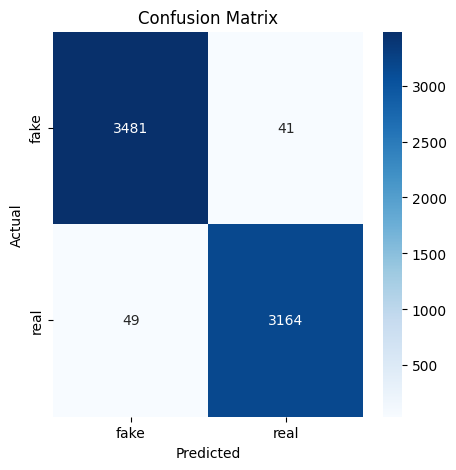

In [21]:
y_pred = baseline_model.predict(X_val)

print(classification_report(y_val, y_pred, target_names=["fake", "real"]))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["fake", "real"], yticklabels=["fake", "real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Optional: Quick PyTorch Feedforward Model

In [24]:
# Small FFNN for demonstration
input_dim = X_train.shape[1]
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
ffnn_model = FFNN(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ffnn_model.parameters(), lr=1e-3)

### Training Loop (Few Epochs)

In [25]:
for epoch in range(3):
    ffnn_model.train()
    total_loss = 0
    for X_batch, y_batch in train_dl:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = ffnn_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_dl):.4f}")

Epoch 1, Loss: 0.0778
Epoch 2, Loss: 0.0068
Epoch 3, Loss: 0.0014


### Validation Loop

              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      3522
        real       0.99      0.99      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



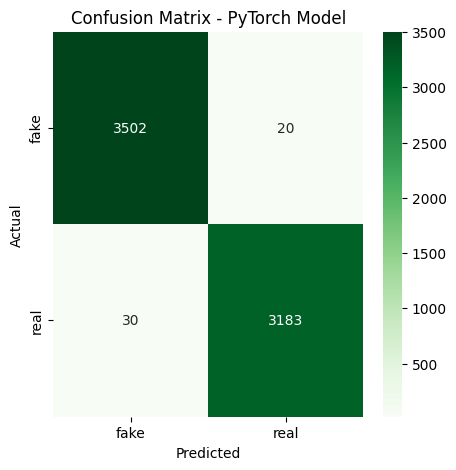

In [26]:
ffnn_model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for X_batch, y_batch in val_dl:
        X_batch = X_batch.to(device)
        logits = ffnn_model(X_batch)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

print(classification_report(all_targets, all_preds, target_names=["fake", "real"]))

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["fake", "real"], yticklabels=["fake", "real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - PyTorch Model")
plt.show()

## Observations
- Dataset is moderately balanced between fake and real classes.
- TF-IDF + Logistic Regression baseline performs reasonably well.
- Misclassifications often occur on very short or ambiguous articles.
- PyTorch feedforward network shows similar performance; transformer upgrade can improve metrics.

## Conclusion
This notebook validated the feasibility of text-based fake news detection using both:
- Classical ML (TF-IDF + Logistic Regression)
- Lightweight neural networks (PyTorch feedforward)

The system is ready for:
- Full training scripts (`train.py`)
- API-based inference (`predict.py`)
- Deployment, monitoring, and production scaling